## Returns Analysis
* Get stock data as a dataframe
* Plotting stock price 
* Log Returns
    * Daily Log Returns Charts
    * Daily Log Returns vs Normal Distribution Charts
    * Daily returns and variance relative to prior day as a DataFrame
    * Cumlative returns, variance, kurtosis, and skewness as a DataFrame
* Other Charts & Functions
    * Plot correlation matrix for multiple tickers
    * Get monthly returns for tickers
    * Plot monthly returns heatmap
    * Plot relative returns (ie vs benchmark ticker)

## Future Demonstration (not in this notebook)
* Using pyxll, create an Excel template to standardize returns analysis
* Part of a larger analysis, which includes returns analysis, fundemental analysis, and technical analysis
* End Goal: presentable document with scoring element
* Note: fucntions need to be slightly modified to work with pyxll+Excel, but it will all stem from this code

In [1]:
# Import Libraries

import os
import subprocess
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm, kurtosis, skew
import math

In [2]:
# All Parameters

ticker_main = 'AAPL'
ticker_comp1 = 'MSFT'
ticker_comp2 = 'GOOG'
ticker_comp3 = 'AMZN'
ticker_market_benchmark = 'SPY'
ticker_segment_benchmark = 'XLK'

### Key Helper Functions
* Get stock data as a dataframe
* Plotting stock price 

In [3]:
def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

#Example
tickers = ['AAPL','MSFT']
start_date = '2020-01-01'
end_date = '2023-01-01'

get_stock_data(tickers, start_date, end_date).head()

[*********************100%%**********************]  2 of 2 completed


,AAPL,MSFT
Date,,
2020-01-02,73.152649,154.779510
2020-01-03,72.441452,152.852219
2020-01-06,73.018692,153.247330
2020-01-07,72.675285,151.850067
2020-01-08,73.844353,154.268784


[*********************100%%**********************]  1 of 1 completed


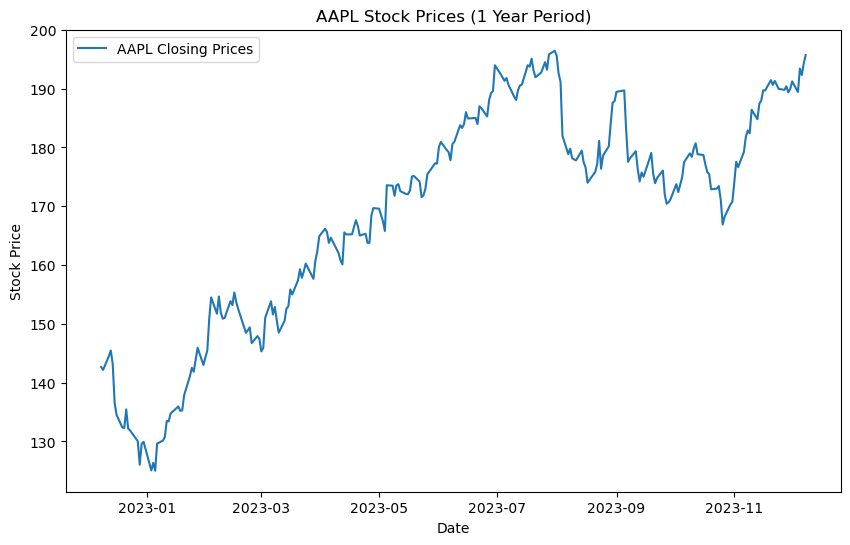

In [4]:
def plot_stock_prices(ticker, years=1):
    # Calculate the start date based on the number of years specified
    start_date = pd.Timestamp.now() - pd.DateOffset(years=years)
    
    # Fetch historical stock data using yfinance
    data = yf.download(ticker, start=start_date, end=pd.Timestamp.now())
    
    # Plotting the closing prices without the grid
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label=f'{ticker} Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f'{ticker} Stock Prices ({years} Year{"s" if years > 1 else ""} Period)')
    plt.legend()
    plt.grid(False)  # Remove the grid
    plt.show()

# Example usage
plot_stock_prices('AAPL', years=1)  # This will plot Apple Inc. (AAPL) closing prices for the last 1 year

### Log Returns
* Daily Log Returns Charts
* Daily Log Returns vs Normal Distribution Charts
* Daily returns and variance relative to prior day as a DataFrame
* Cumlative returns, variance, kurtosis, and skewness as a DataFrame

Received Ticker: AAPL, Comparison Tickers: MSFT, GOOG, AMZN
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\jross\AppData\Local\Temp\ipykernel_14028\342531892.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(primary_data.index.strftime('%Y-%m-%d'), rotation=45)


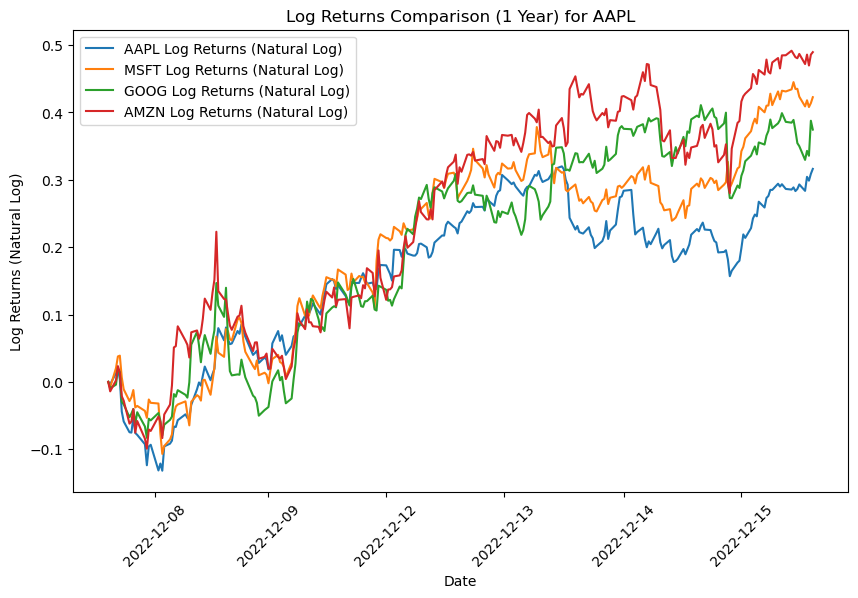

In [5]:
def plot_log_returns(ticker, years=1, comparison_ticker1=None, comparison_ticker2=None, comparison_ticker3=None):
    print(f'Received Ticker: {ticker}, Comparison Tickers: {comparison_ticker1}, {comparison_ticker2}, {comparison_ticker3}')

    fig, ax = plt.subplots(figsize=(10, 6))

    end_date = datetime.now()
    start_date = end_date - timedelta(days=365 * years)

    # Fetch data for the primary ticker
    try:
        primary_data = yf.download(ticker, start=start_date, end=end_date)
        primary_data['Log_Returns'] = primary_data['Close'].apply(lambda x: np.nan if x <= 0 else math.log(x / primary_data['Close'][0]))
        ax.plot(primary_data.index, primary_data['Log_Returns'], label=f'{ticker} Log Returns (Natural Log)')

        # Fetch and plot data for comparison tickers if provided
        for comp_ticker in [comparison_ticker1, comparison_ticker2, comparison_ticker3]:
            if comp_ticker:
                try:
                    comparison_data = yf.download(comp_ticker, start=start_date, end=end_date)
                    comparison_data['Log_Returns'] = comparison_data['Adj Close'].apply(lambda x: np.nan if x <= 0 else math.log(x / comparison_data['Adj Close'][0]))
                    ax.plot(comparison_data.index, comparison_data['Log_Returns'], label=f'{comp_ticker} Log Returns (Natural Log)')
                except Exception as e:
                    print(f"Error fetching data for {comp_ticker}: {e}")

        ax.set(xlabel='Date', ylabel='Log Returns (Natural Log)',
               title=f'Log Returns Comparison ({years} {"Year" if years == 1 else "Years"}) for {ticker}')
        ax.legend()
        ax.grid(False)  # Remove the grid
        ax.set_xticklabels(primary_data.index.strftime('%Y-%m-%d'), rotation=45)

        # Display the plot
        plt.show()

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Plot Log Returns
plot_log_returns(ticker_main, years=1, comparison_ticker1=ticker_comp1, comparison_ticker2=ticker_comp2, comparison_ticker3=ticker_comp3)

In [6]:
def plot_histogram(ticker, years=1):
    # Convert years to integer
    years = int(years)

    # Fetch historical data for the ticker
    try:
        data = yf.download(ticker, period=f"{years}y")

        # Calculate daily returns
        daily_log_returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1)).dropna()

        # Plot histogram
        plt.figure(figsize=(8, 6))
        plt.hist(daily_log_returns, bins=30, density=True, alpha=0.7, color='blue', label='Historical Data')

        # Plot normal distribution curve (bell curve)
        mean_return = daily_log_returns.mean()
        std_dev_return = daily_log_returns.std()
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mean_return, std_dev_return)
        plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

        plt.xlabel('Daily Log Returns')
        plt.ylabel('Density')
        plt.title(f'Distribution of Daily Log Returns for {ticker} ({years} Year{"s" if years > 1 else ""} Period)')
        plt.legend()

        # Display the plot
        plt.show()
#         plot(plt.gcf())

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

In [7]:
def plot_kde(ticker, years=1):
    # Convert years to integer
    years = int(years)

    # Fetch historical data for the ticker
    try:
        data = yf.download(ticker, period=f"{years}y")

        # Calculate daily returns
        daily_log_returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1)).dropna()

        # Plot KDE plot
        plt.figure(figsize=(8, 6))
        sns.kdeplot(daily_log_returns, fill=True, color='blue', label='KDE Plot (Historical Data)')

        # Plot normal distribution curve (bell curve)
        mean = daily_log_returns.mean()
        std_dev = daily_log_returns.std()
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mean, std_dev)
        plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

        plt.xlabel('Daily Log Returns')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimation of Daily Log Returns for {ticker} ({years} Year{"s" if years > 1 else ""} Period)')
        plt.legend()

        # Display the plot
        plt.show()

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

In [8]:
def plot_box_plot(ticker, years=1):
    # Convert years to integer
    years = int(years)

    # Fetch historical data for the ticker
    try:
        data = yf.download(ticker, period=f"{years}y")

        # Calculate daily returns
        daily_log_returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1)).dropna()

        # Plot box plot
        plt.figure(figsize=(8, 6))
        plt.boxplot(daily_log_returns.dropna(), vert=False)
        plt.xlabel('Daily Log Returns')
        plt.title(f'Box Plot of Daily Log Returns for {ticker} ({years} Year{"s" if years > 1 else ""} Period)')

        # Display the plot
        plt.show()
#         plot(plt.gcf())

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

#### Example Output Of Returns Analysis
* Log returns
* Histogram
* KDE
* Box Plot

Received Ticker: AAPL, Comparison Tickers: MSFT, GOOG, AMZN
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\jross\AppData\Local\Temp\ipykernel_14028\342531892.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(primary_data.index.strftime('%Y-%m-%d'), rotation=45)


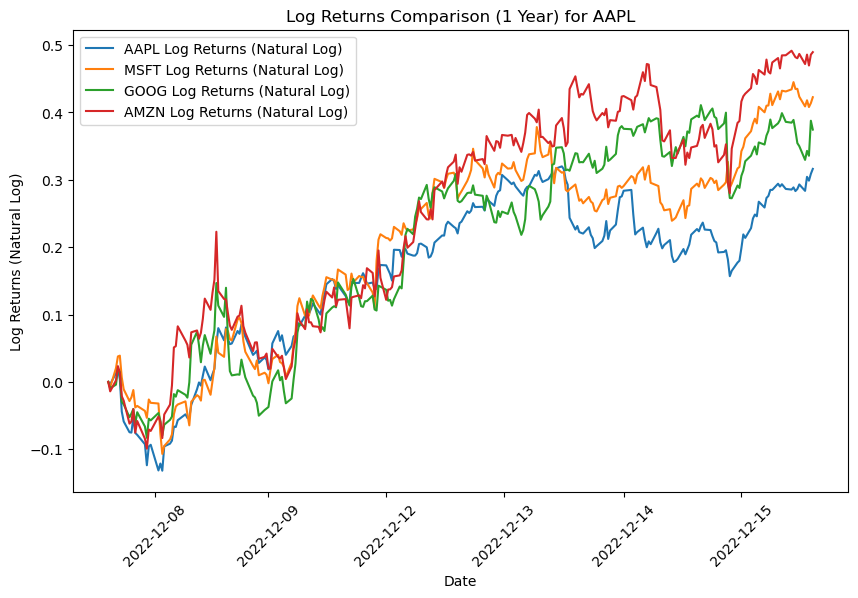

In [9]:
# Plot Log Returns
plot_log_returns(ticker_main, years=1, comparison_ticker1=ticker_comp1, comparison_ticker2=ticker_comp2, comparison_ticker3=ticker_comp3)

[*********************100%%**********************]  1 of 1 completed


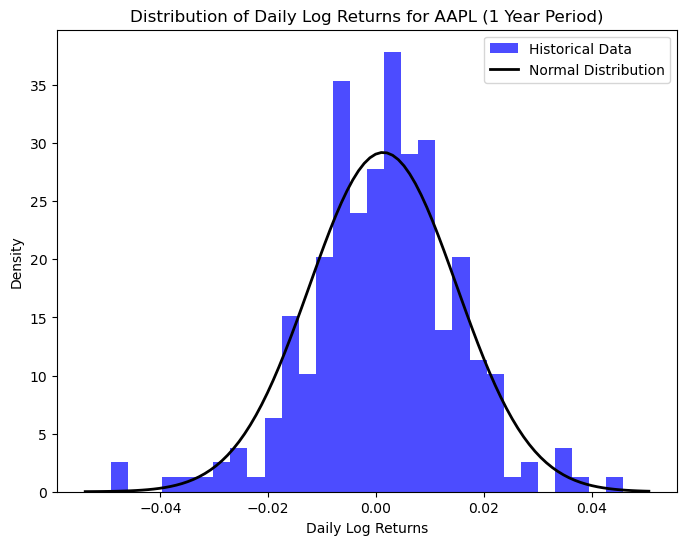

In [10]:
# Histogram
plot_histogram(ticker_main, 1)

[*********************100%%**********************]  1 of 1 completed


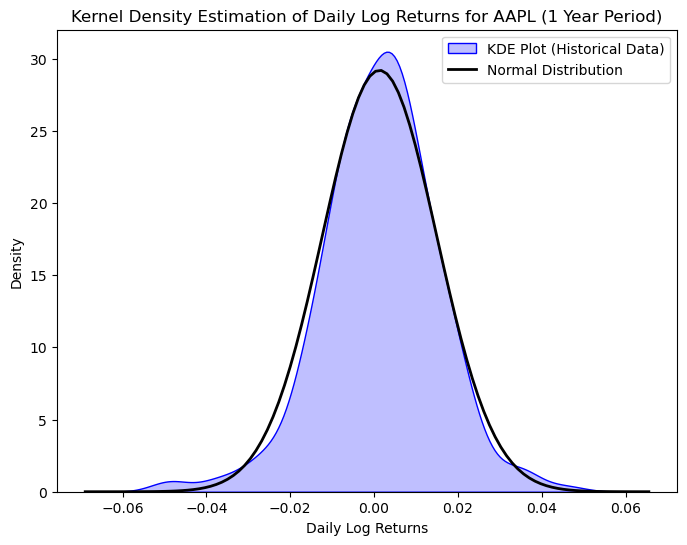

In [11]:
# KDE
plot_kde(ticker_main, 1)

[*********************100%%**********************]  1 of 1 completed


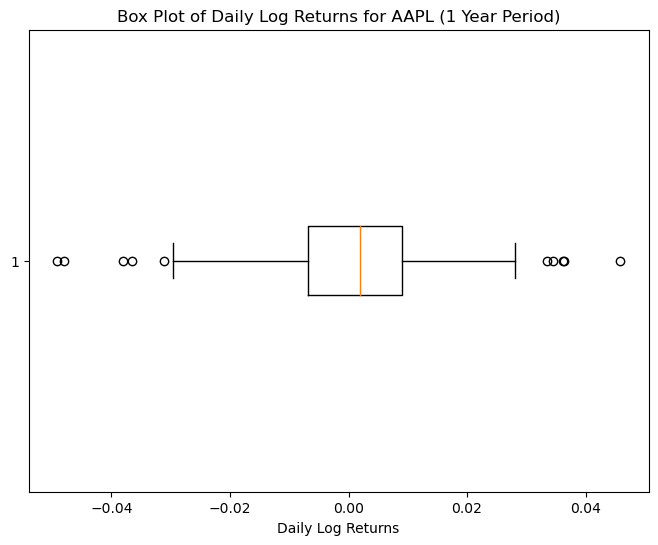

In [12]:
# Box Plot
plot_box_plot(ticker_main, 1)

#### Log Daily Returns Relative to Prior Day
* Daily Average Log Returns
* Daily Average Variance
* Annualized Average Log Returns
* Annualized Average Variance

In [13]:
def daily_returns_to_prior_day(ticker_list, years=1):
    # Convert years to integer
    years = int(years)

    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame(index=ticker_list)

    for ticker in ticker_list:
        try:
            # Fetch historical data for the ticker
            data = yf.download(ticker, period=f"{years}y")

            # Calculate daily returns
            daily_log_returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1)).dropna()

            # Calculate metrics
            daily_avg_log_returns = daily_log_returns.mean()
            daily_avg_variance = daily_log_returns.var()

            # Annualize metrics
            annualized_log_returns = daily_avg_log_returns * 252  # 252 trading days in a year
            annualized_variance = daily_avg_variance * 252

            # Store metrics in the DataFrame
            metrics_df.loc[ticker, 'Daily_Avg_Log_Returns'] = daily_avg_log_returns
            metrics_df.loc[ticker, 'Daily_Avg_Variance'] = daily_avg_variance
            metrics_df.loc[ticker, 'Annualized_Log_Returns'] = annualized_log_returns
            metrics_df.loc[ticker, 'Annualized_Variance'] = annualized_variance

        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")

    return metrics_df

ticker_list = [ticker_main, ticker_comp1, ticker_comp2, ticker_comp3, ticker_market_benchmark, ticker_segment_benchmark]
# ticker_list = [ticker_main]
metrics_result = daily_returns_to_prior_day(ticker_list, years=1)
metrics_result

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Daily_Avg_Log_Returns,Daily_Avg_Variance,Annualized_Log_Returns,Annualized_Variance
AAPL,0.001301,0.000187,0.327857,0.047035
MSFT,0.001723,0.000262,0.434173,0.065986
GOOG,0.001536,0.000389,0.387070,0.097970
AMZN,0.002015,0.000452,0.507668,0.113811
SPY,0.000691,0.000074,0.174141,0.018652
XLK,0.001456,0.000152,0.366990,0.038320


#### Log Returns Relative to First Day (Cumulative Returns)
* Daily Average Log Returns
* Daily Average Variance
* Annualized Log Returns
* Annualized Variance
* Kertosis
* Skewness
* Excess Kertosis
* Excess Skewness

In [14]:
# Function to calculate cumulative returns for a given ticker and period
def calculate_cumulative_returns(ticker, years=1):
    end_date = pd.to_datetime("today").normalize()
    start_date = end_date - pd.DateOffset(years=years)

    # Fetch historical data for the ticker
    data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate cumulative returns relative to the first day
    data['Cumulative_Returns'] = np.log(data['Adj Close'] / data['Adj Close'].iloc[0])

    # Drop rows with NaN returns
    data = data.dropna(subset=['Cumulative_Returns'])

    return data[['Cumulative_Returns']]

# Function to calculate cumulative return metrics for a given DataFrame
def calculate_cumulative_return_metrics(cumulative_returns_df, ticker):
    # Shift cumulative returns by 1 to align with daily returns
    cumulative_returns_shifted = cumulative_returns_df['Cumulative_Returns'].shift(1).dropna()

    # Calculate average daily log returns
    avg_daily_log_returns = cumulative_returns_shifted.mean()

    # Calculate daily variance
    daily_variance = cumulative_returns_shifted.var()

    # Calculate average annual log returns (assuming 252 trading days in a year)
    avg_annual_log_returns = avg_daily_log_returns * 252

    # Calculate annual variance (scaled by the number of trading days)
    annual_variance = daily_variance * 252

    # Calculate kurtosis and skewness
    kurt = kurtosis(cumulative_returns_shifted, fisher=False)
    skew_val = skew(cumulative_returns_shifted)

    # Calculate excess kurtosis and skewness compared to a normal distribution
    normal_kurtosis = 3
    normal_skewness = 0
    excess_kurtosis = kurt - normal_kurtosis
    excess_skewness = skew_val - normal_skewness

    # Create a DataFrame with the calculated metrics
    metrics_df = pd.DataFrame({
        'Daily_Avg_Log_Returns': avg_daily_log_returns,
        'Daily_Avg_Variance': daily_variance,
        'Annualized_Log_Returns': avg_annual_log_returns,
        'Annualized_Variance': annual_variance,
        'Kurtosis': kurt,
        'Skewness': skew_val,
        'Excess_Kurtosis': excess_kurtosis,
        'Excess_Skewness': excess_skewness
    }, index=[ticker])


    return metrics_df

# Function to calculate and display cumulative return metrics for a list of tickers
def calculate_and_display_metrics(ticker_list, years=1):
    all_metrics = pd.DataFrame()

    for ticker in ticker_list:
        df = calculate_cumulative_returns(ticker, years)
        metrics = calculate_cumulative_return_metrics(df, ticker)
        all_metrics = pd.concat([all_metrics, metrics])

    return all_metrics

# Example usage
ticker_list = [ticker_main, ticker_comp1, ticker_comp2, ticker_comp3, ticker_market_benchmark, ticker_segment_benchmark]
all_metrics = calculate_and_display_metrics(ticker_list, years=1)
# print(all_metrics)
all_metrics

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Daily_Avg_Log_Returns,Daily_Avg_Variance,Annualized_Log_Returns,Annualized_Variance,Kurtosis,Skewness,Excess_Kurtosis,Excess_Skewness
AAPL,0.164214,0.013533,41.381916,3.410427,2.675009,-0.795365,-0.324991,-0.795365
MSFT,0.206240,0.020185,51.972539,5.086523,2.042239,-0.474695,-0.957761,-0.474695
GOOG,0.204732,0.022801,51.592416,5.745891,1.710792,-0.397509,-1.289208,-0.397509
AMZN,0.247234,0.027908,62.302891,7.032912,1.735398,-0.315234,-1.264602,-0.315234
SPY,0.071625,0.003150,18.049616,0.793902,1.858436,-0.196353,-1.141564,-0.196353
XLK,0.176823,0.013619,44.559400,3.431901,2.021386,-0.460328,-0.978614,-0.460328


### Other Charts & Functions
* Plot correlation matrix for multiple tickers
* Get monthly returns for tickers
* Plot monthly returns heatmap
* Plot relative returns (ie vs benchmark ticker)

[*********************100%%**********************]  4 of 4 completed


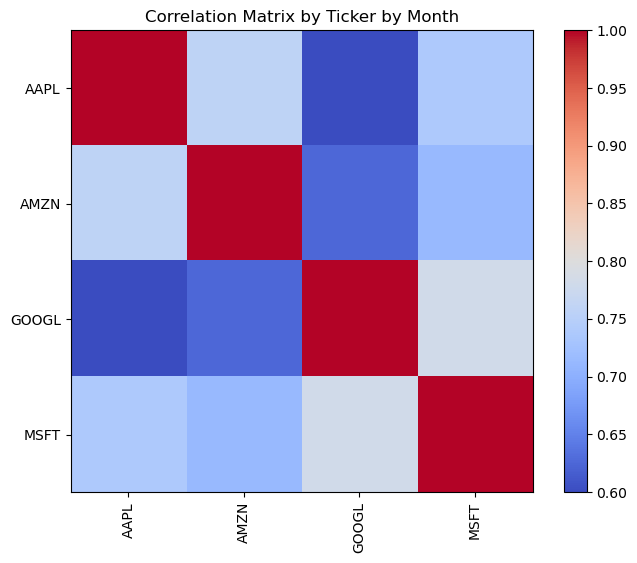

In [15]:
def plot_correlation_matrix(ticker1, ticker2, ticker3, ticker4, start_date, end_date):
    # Get stock data for the specified tickers and date range
    tickers = [ticker1, ticker2, ticker3, ticker4]
    stock_data = get_stock_data(tickers, start_date, end_date)
    
    # Calculate monthly returns for the tickers
    monthly_returns = stock_data.resample('M').ffill().pct_change().dropna()
    
    # Calculate correlation matrix for monthly returns
    correlation_matrix = monthly_returns.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.title('Correlation Matrix by Ticker by Month')
    plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation='vertical')
    plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
    plt.show()

# Example usage
start_date = '2020-01-01'
end_date = '2023-01-01'
ticker1 = 'AAPL'
ticker2 = 'MSFT'
ticker3 = 'GOOGL'
ticker4 = 'AMZN'

plot_correlation_matrix(ticker1, ticker2, ticker3, ticker4, start_date, end_date)

[*********************100%%**********************]  4 of 4 completed


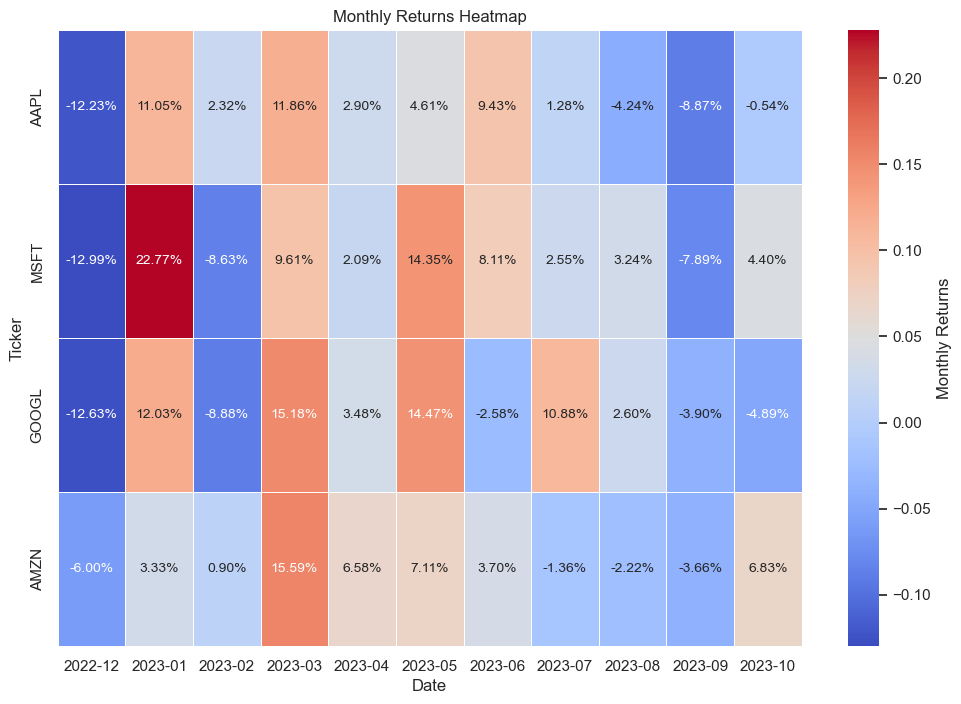

In [16]:
def get_monthly_returns(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    monthly_returns = data.resample('M').ffill().pct_change().dropna()
    return monthly_returns

def plot_monthly_returns_heatmap(ticker1, ticker2, ticker3, ticker4, start_date, end_date):
    tickers = [ticker1, ticker2, ticker3, ticker4]
    monthly_returns = get_monthly_returns(tickers, start_date, end_date)
    
    plt.figure(figsize=(12, 8))
    sns.set(font_scale=1)  # Set font size for better readability
    
    ax = sns.heatmap(monthly_returns.T, cmap='coolwarm', annot=True, annot_kws={'size': 10},
                     linewidths=.5, fmt='.2%', cbar_kws={'label': 'Monthly Returns'},
                     cbar=True, xticklabels=monthly_returns.index.strftime('%Y-%m'))  # Set x-axis labels
    
    ax.set_yticks([i + 0.5 for i in range(len(tickers))])  # Set ticks in the middle of each row
    ax.set_yticklabels(tickers)  # Set tick labels for the y-axis
    
    plt.xlabel('Date')
    plt.ylabel('Ticker')
    plt.title('Monthly Returns Heatmap')
    plt.show()

# Example usage
start_date = '2022-11-01'
end_date = '2023-10-31'
ticker1 = 'AAPL'
ticker2 = 'MSFT'
ticker3 = 'GOOGL'
ticker4 = 'AMZN'

plot_monthly_returns_heatmap(ticker1, ticker2, ticker3, ticker4, start_date, end_date)

[*********************100%%**********************]  4 of 4 completed


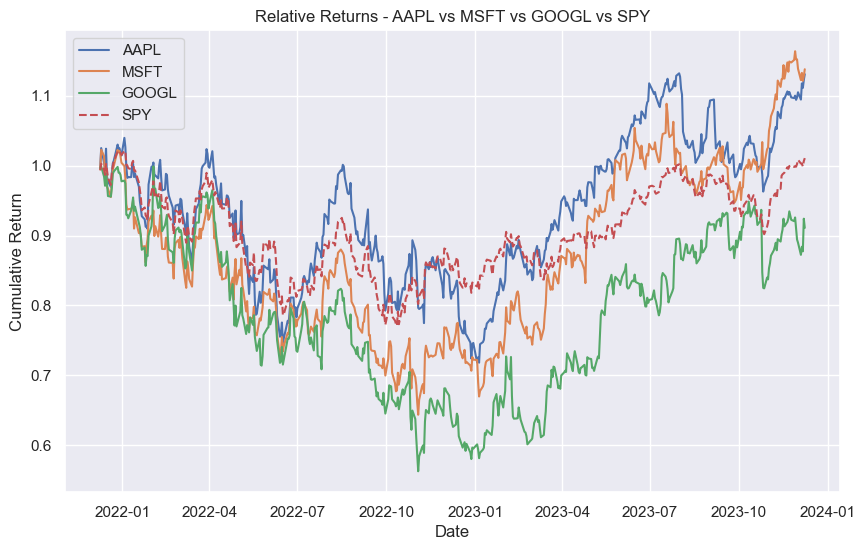

In [17]:
#Relative Returns
def calculate_relative_returns(ticker, years=1, comparison_ticker1=None, comparison_ticker2=None, benchmark_ticker='SPY'):
    # Fetch historical stock prices
    end_date = pd.to_datetime('today')
    start_date = end_date - pd.DateOffset(years=years)

    tickers = [ticker, comparison_ticker1, comparison_ticker2, benchmark_ticker]
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

    # Calculate daily returns
    returns = data.pct_change().dropna()

    # Calculate cumulative returns
    cumulative_returns = (1 + returns).cumprod()

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot Ticker
    plt.plot(cumulative_returns[ticker], label=ticker)

    # Plot Comparison Tickers
    if comparison_ticker1:
        plt.plot(cumulative_returns[comparison_ticker1], label=comparison_ticker1)
    if comparison_ticker2:
        plt.plot(cumulative_returns[comparison_ticker2], label=comparison_ticker2)

    # Plot Benchmark Ticker
    plt.plot(cumulative_returns[benchmark_ticker], label=benchmark_ticker, linestyle='--')

    # Customize the plot
    plt.title(f'Relative Returns - {ticker} vs {comparison_ticker1} vs {comparison_ticker2} vs {benchmark_ticker}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage:
calculate_relative_returns('AAPL', years=2, comparison_ticker1='MSFT', comparison_ticker2='GOOGL', benchmark_ticker='SPY')